In [11]:

import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from centrex_tlf import states, hamiltonian
from centrex_trajectories.utils import fit_stark_potential 
from scipy import constants



In [12]:

Energies = []

# generate states up to J=10
QN = states.generate_uncoupled_states_ground(Js=np.arange(20))

# generate the X hamiltonian terms
H = hamiltonian.generate_uncoupled_hamiltonian_X(QN)

# create a function outputting the hamiltonian as a function of E and B
Hfunc = hamiltonian.generate_uncoupled_hamiltonian_X_function(H)
# V/cm
Ez = np.linspace(0, 50e3, 101)

# generate the Hamiltonian for (almost) zero field, add a small field to make states
# non-degenerate
Hi = Hfunc(E=[0, 0, 1e-3], B=[0, 0, 1e-3])
E, V = np.linalg.eigh(Hi)

# get the true superposition-states of the system
QN_states = hamiltonian.matrix_to_states(V, QN)

# original eigenvectors used in tracking states as energies change order
V_track = V.copy()

# empty array for storing energies
energy = np.empty([Ez.size, len(QN)], dtype=np.complex128)

# iterate over the electric field values
for idx, Ei in enumerate(Ez):
    Hi = Hfunc(E=[0, 0, Ei], B=[0, 0, 1e-3])
    E, V = np.linalg.eigh(Hi)

    # sort indices to keep the state order the same
    indices = np.argmax(np.abs(V_track.conj().T @ V), axis=1)
    energy[idx, :] = E[indices]
    V_track[:, :] = V[:, indices]

stark_potential_j_mj = []
for j in range(0,9):
    stark_potential_mj = []
    for mj in range(-j,j+1):

        start=time.time()
        # indices of the J, mJ states
        indices_J_mJ = [
            idx
            for idx, s in enumerate(QN_states)
            if s.largest.J == j and s.largest.mJ == mj
        ]
        # plot the J=2, mJ=0 Stark curves
        # ax.plot(
        #     Ez,
        #     (energy.real[:, indices_J2_mJ0] - energy.real[:, indices_J2_mJ0][0, 0])
        #     / (2 * np.pi * 1e9), label=f"{jup}"
        # )
        stark_potential_mj.append(np.transpose((energy.real[:, indices_J_mJ] - energy.real[:, indices_J_mJ][0, 0])
            / (2 * np.pi * 1e9)))
        
        print(f"task with Jmax=10 J={j} mJ={mj} finished in {time.time()-start}s")
    stark_potential_j_mj.append(stark_potential_mj)

task with Jmax=10 J=0 mJ=0 finished in 1.700148105621338s
task with Jmax=10 J=1 mJ=-1 finished in 1.6179547309875488s
task with Jmax=10 J=1 mJ=0 finished in 1.5979204177856445s
task with Jmax=10 J=1 mJ=1 finished in 1.567272663116455s
task with Jmax=10 J=2 mJ=-2 finished in 1.5500915050506592s
task with Jmax=10 J=2 mJ=-1 finished in 1.5166287422180176s
task with Jmax=10 J=2 mJ=0 finished in 1.519742488861084s
task with Jmax=10 J=2 mJ=1 finished in 1.564183235168457s
task with Jmax=10 J=2 mJ=2 finished in 1.5185847282409668s
task with Jmax=10 J=3 mJ=-3 finished in 1.5637710094451904s
task with Jmax=10 J=3 mJ=-2 finished in 1.5346183776855469s
task with Jmax=10 J=3 mJ=-1 finished in 1.5499799251556396s
task with Jmax=10 J=3 mJ=0 finished in 1.5495712757110596s
task with Jmax=10 J=3 mJ=1 finished in 1.5341811180114746s
task with Jmax=10 J=3 mJ=2 finished in 1.584228515625s
task with Jmax=10 J=3 mJ=3 finished in 1.532435655593872s
task with Jmax=10 J=4 mJ=-4 finished in 1.5689184665679932s

In [13]:
import pickle
with open(f'stark_shifts_all_J_mJ_0_8_Jmax_20.pickle', 'wb') as handle:
    pickle.dump(stark_potential_j_mj, handle, protocol=pickle.HIGHEST_PROTOCOL)      

In [1]:
import pickle
with open(f'stark_shifts_all_J_mJ_0_8_Jmax_20.pickle', 'rb') as handle:
    stark_potential_j_mj=pickle.load(handle)      

In [7]:
Ez = np.linspace(0, 50e3, 101)


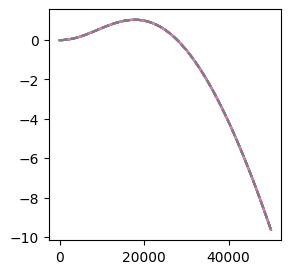

In [8]:
plt.rcParams["figure.figsize"] = (3,3)
for i in range(0,4):
    plt.plot(Ez, stark_potential_j_mj[2][3][i])
    ffit1 = np.polyfit(x=Ez, y=stark_potential_j_mj[2][3][i], deg=11)
    ffit = np.poly1d(ffit1)
    plt.plot(Ez, ffit(Ez), linestyle='dashed')    


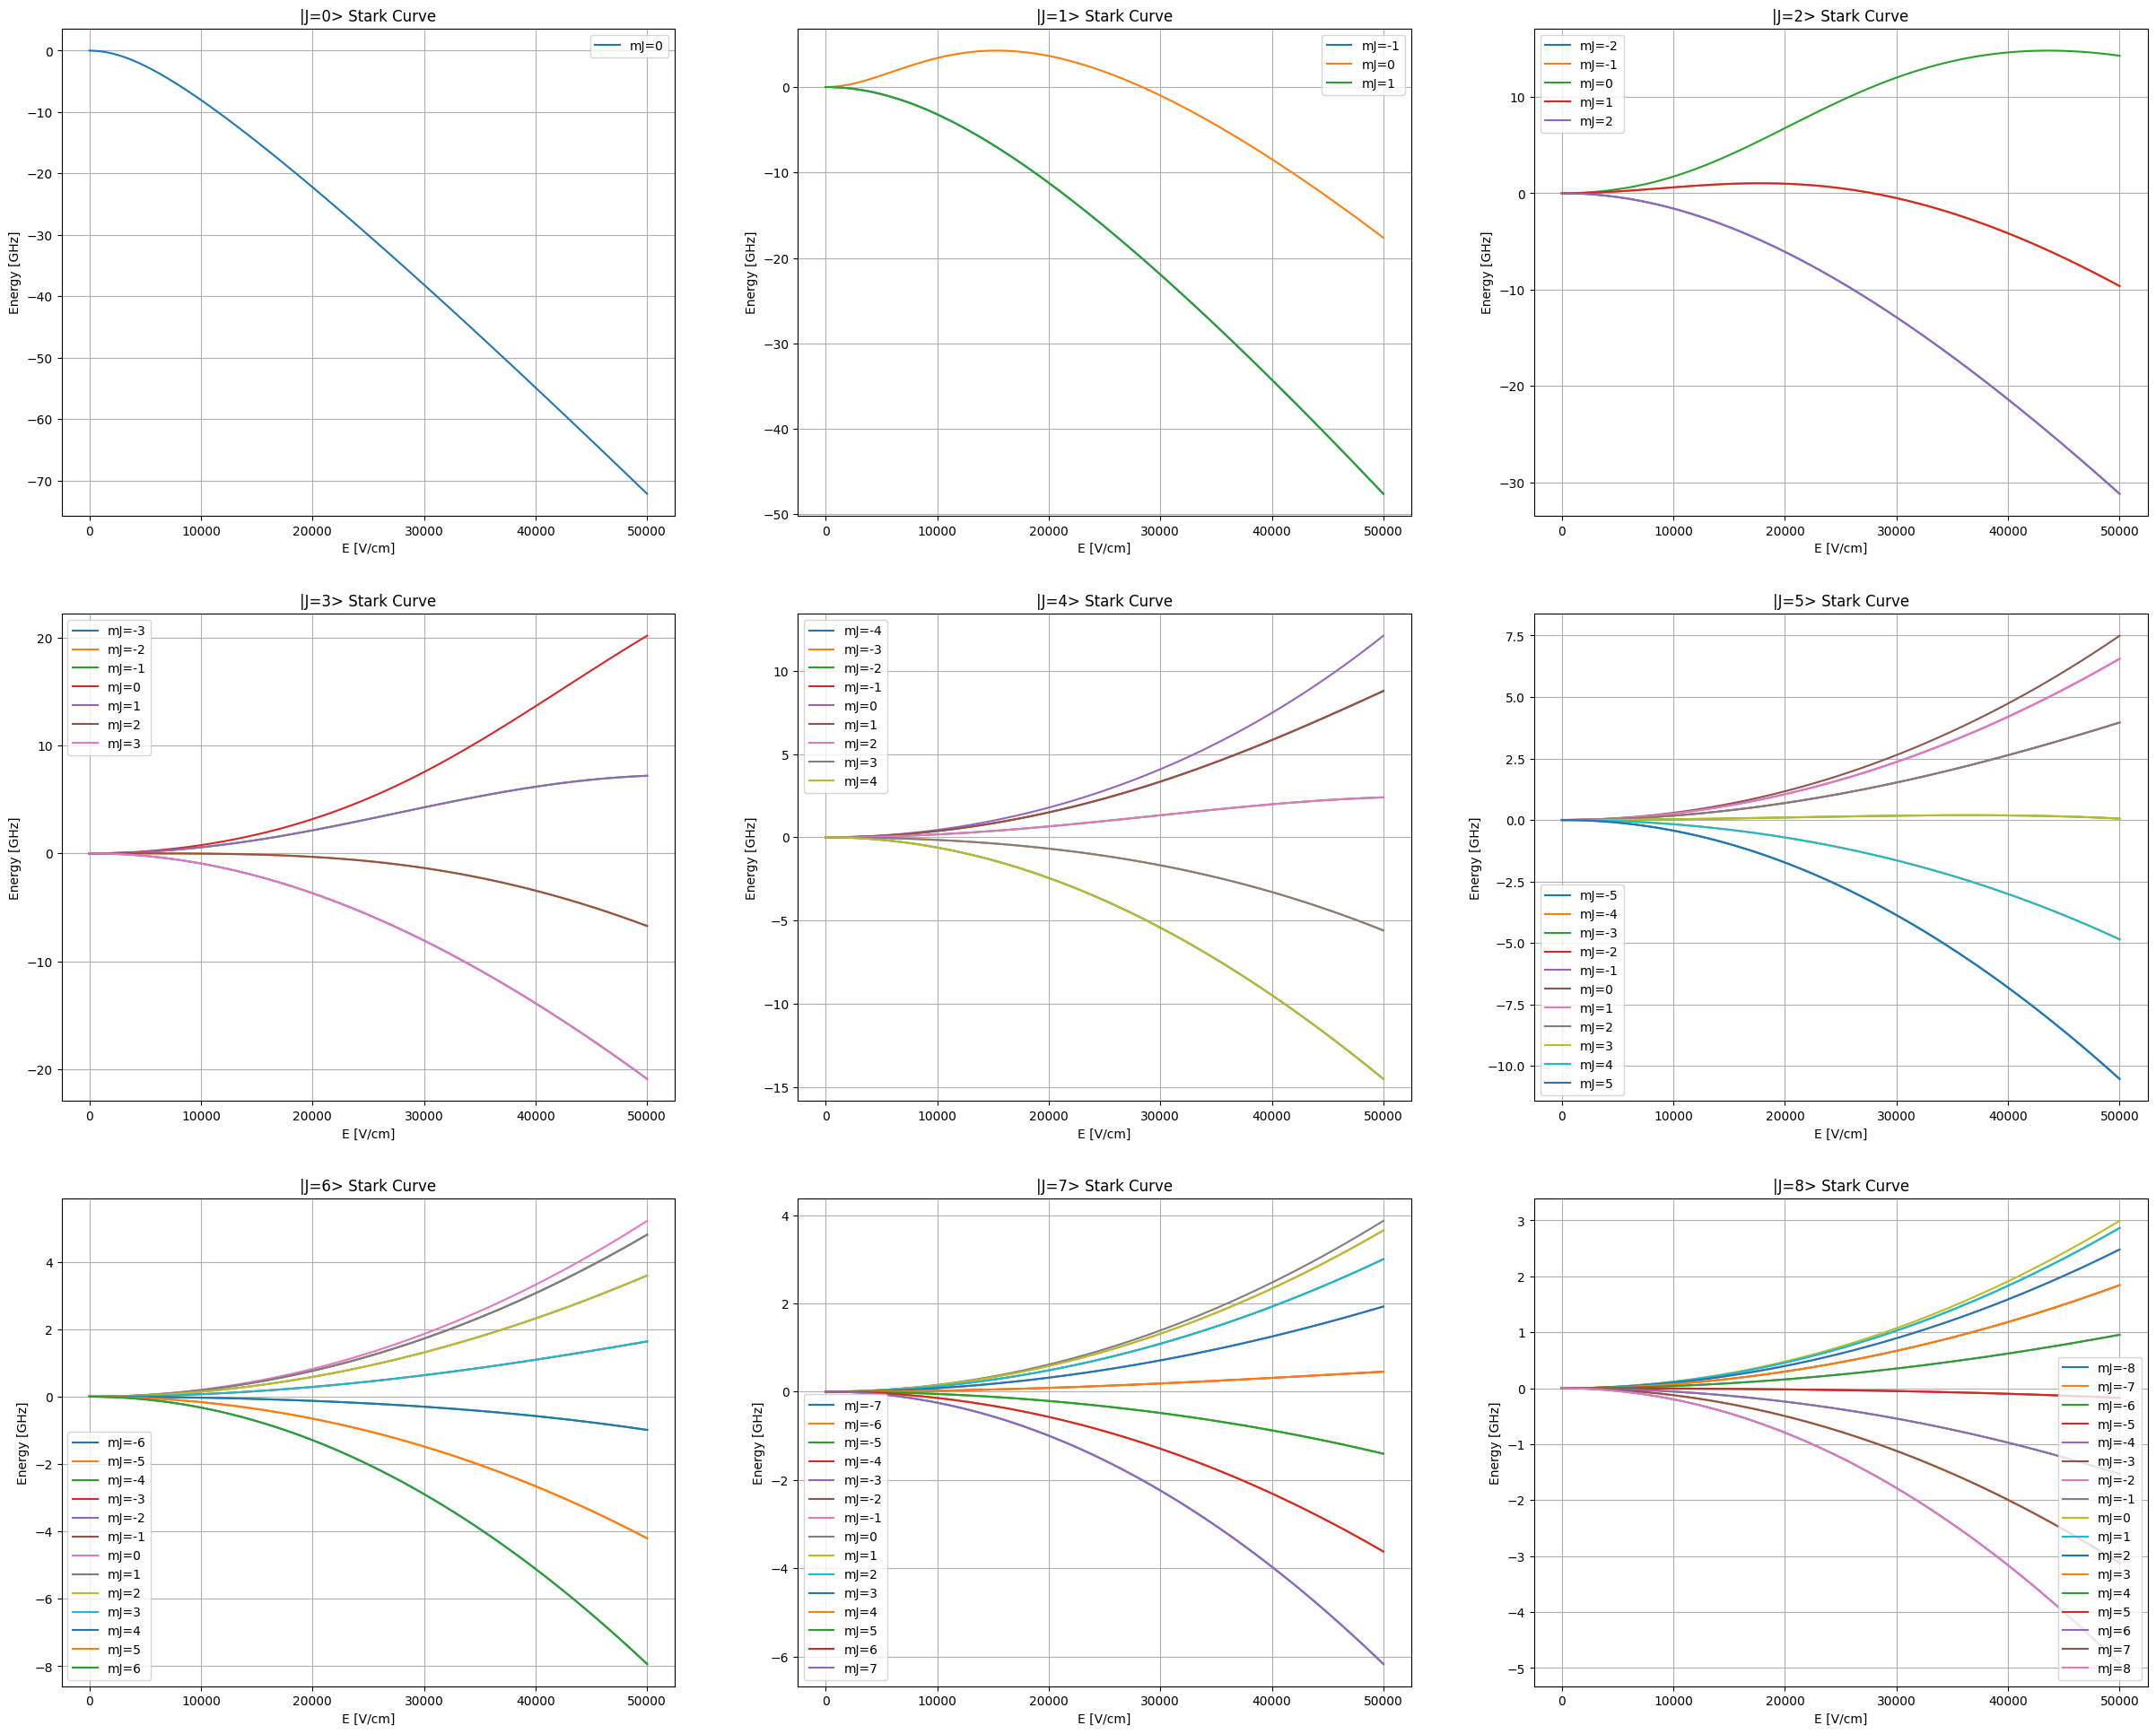

In [10]:
plt.rcParams["figure.figsize"] = (30,24)

fig, axs = plt.subplots(3,3)
J = 0
for i in range(0,3):
    for j in range(0,3):
        for k in range(0, 2*(J)+1):
            p = axs[i, j].plot(Ez, stark_potential_j_mj[J][k][0], label=f"mJ={k-J}")
            # color = p[-1].get_color()
            # ffit = np.polynomial.Polynomial.fit(Ez, stark_potential_j_mj[J][k][0], 11, domain=[])
            # axs[i, j].plot(Ez, ffit(Ez), label=f"mJ={k-J} fit", color=color, linestyle='dashed')
        axs[i, j].set_xlabel("E [V/cm]")
        axs[i, j].set_ylabel("Energy [GHz]")
        axs[i, j].set_title(f"|J={J}> Stark Curve")
        axs[i, j].grid(True)
        axs[i, j].legend()
        J = J+1

        

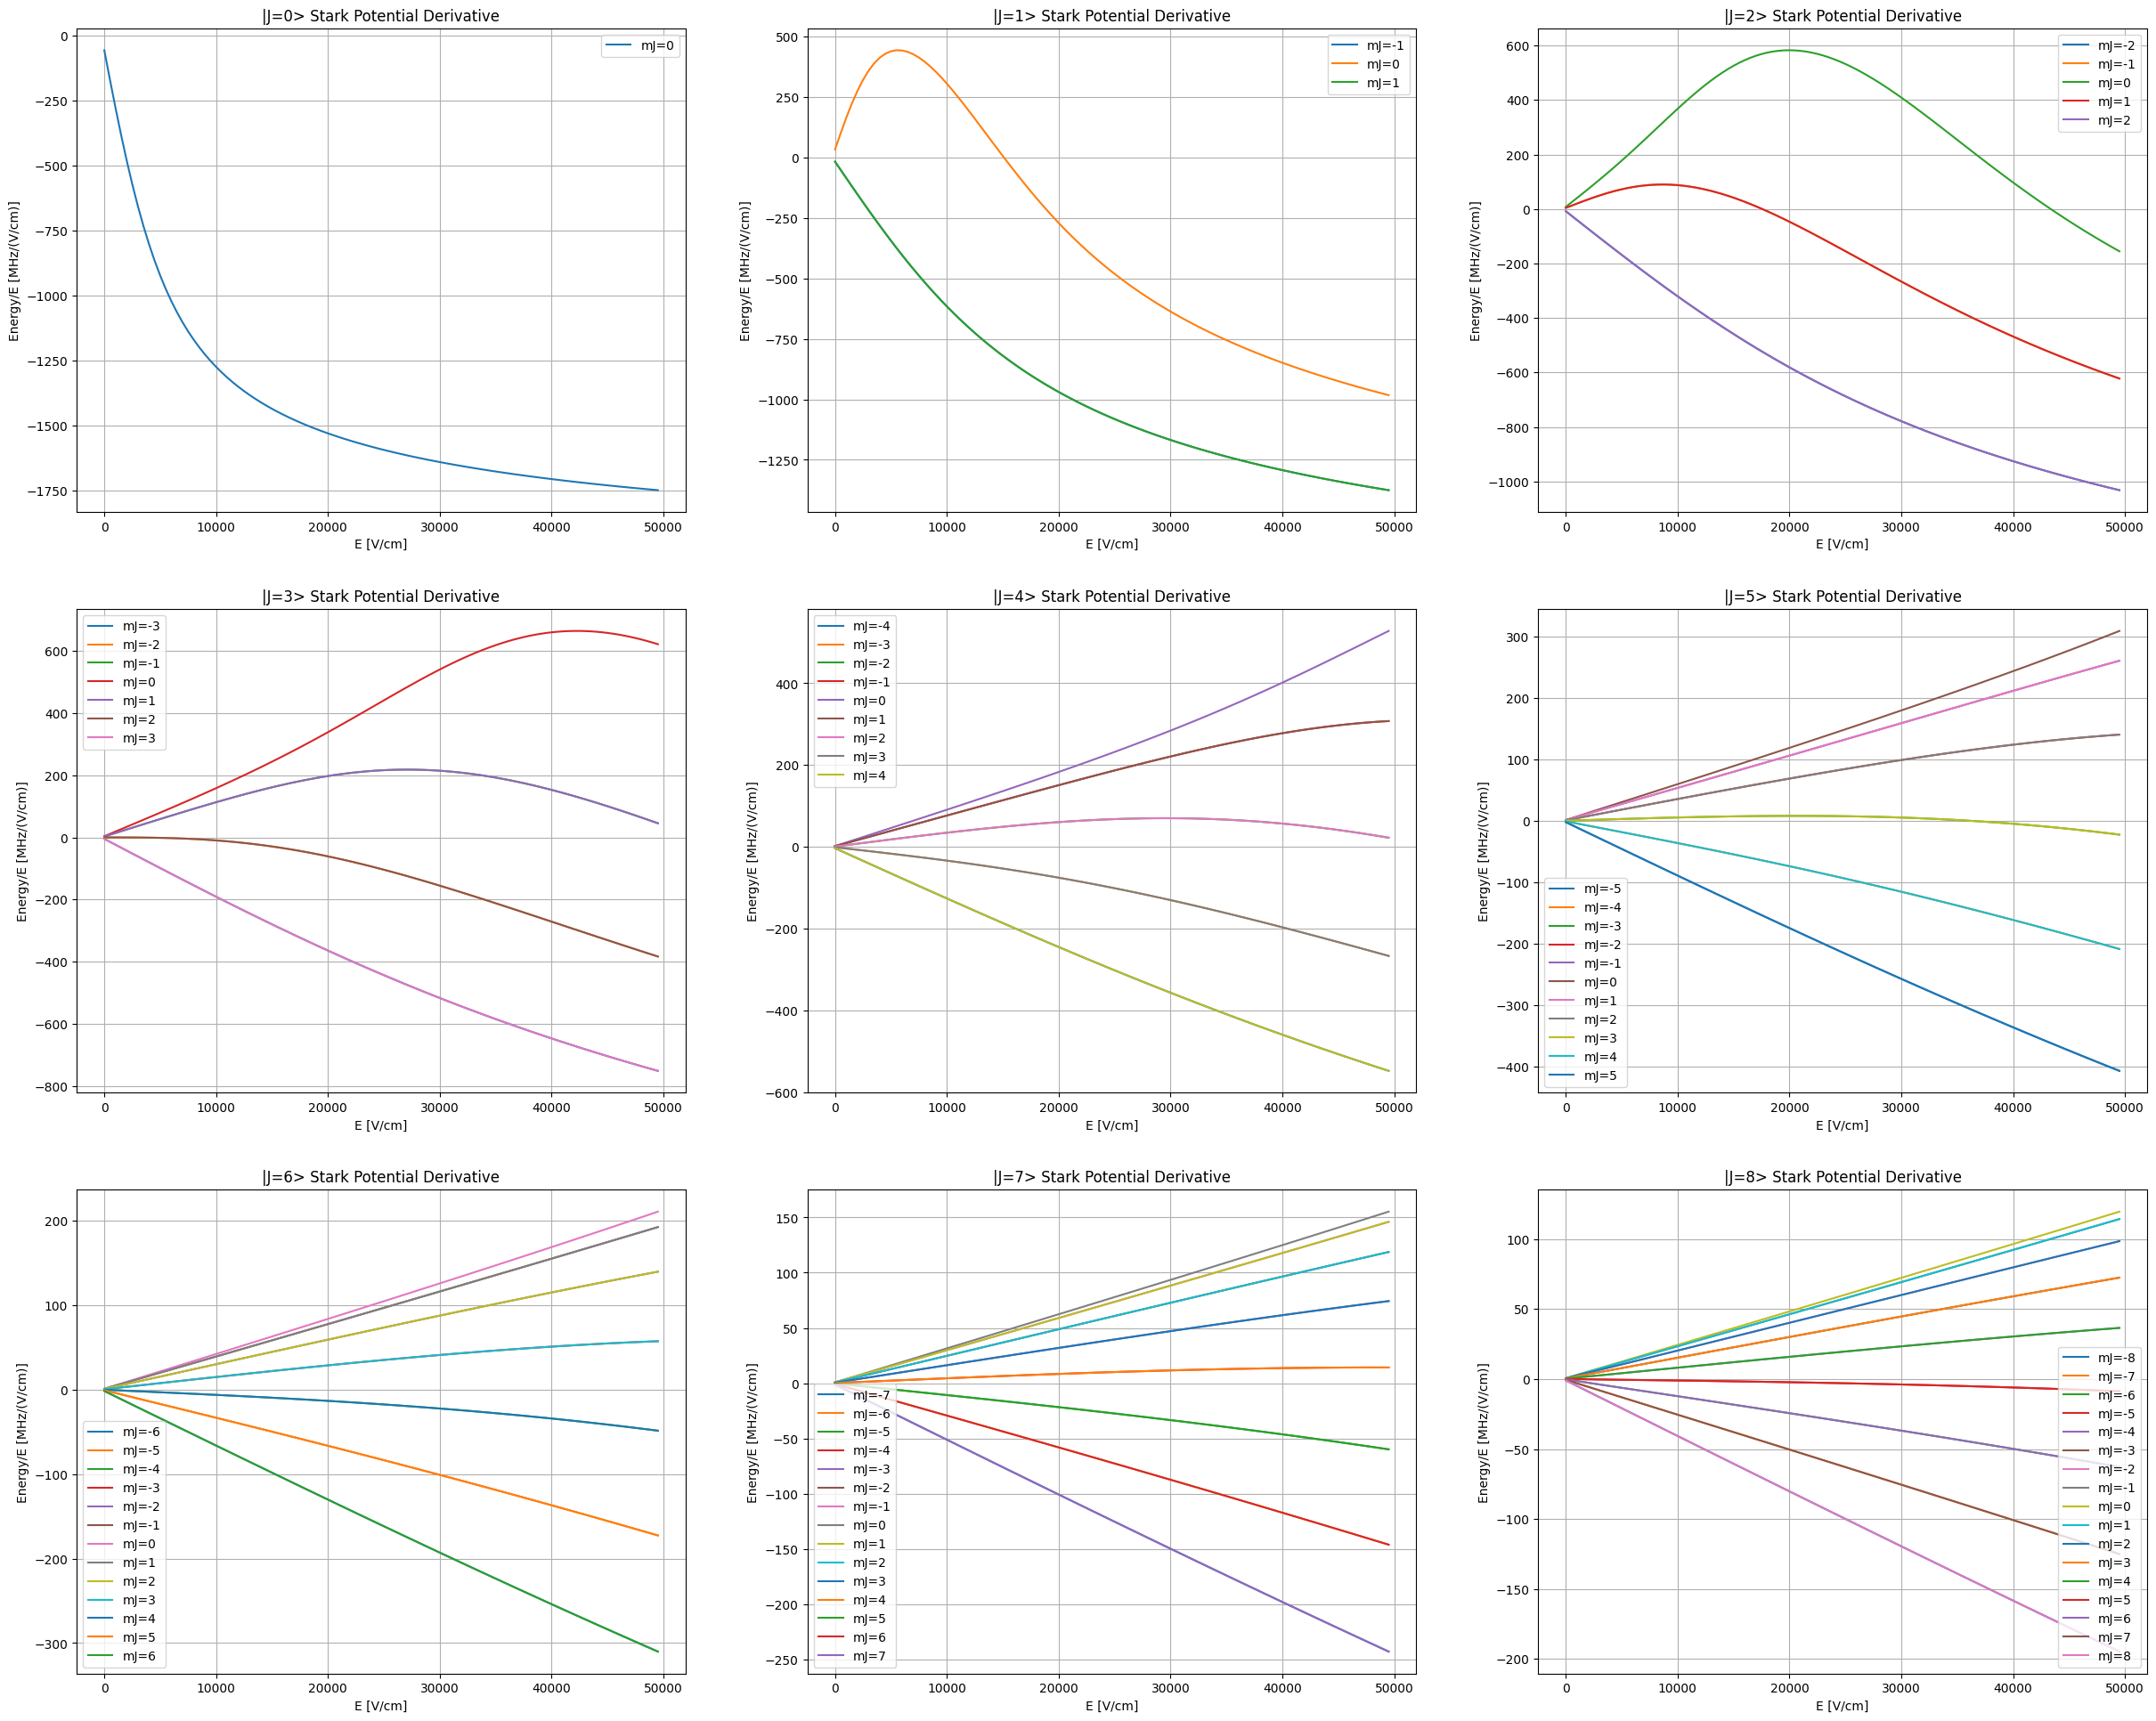

In [18]:
plt.rcParams["figure.figsize"] = (30,24)

fig, axs = plt.subplots(3,3)
J = 0
for i in range(0,3):
    for j in range(0,3):
        for k in range(0, 2*(J)+1):
            axs[i, j].plot(Ez[:-1], np.diff(stark_potential_j_mj[J][k][0])/500*1e6, label=f"mJ={k-J}")
        axs[i, j].set_xlabel("E [V/cm]")
        axs[i, j].set_ylabel("Energy/E [MHz/(V/cm)]")
        axs[i, j].set_title(f"|J={J}> Stark Potential Derivative")
        axs[i, j].grid(True)
        axs[i, j].legend()
        J = J+1

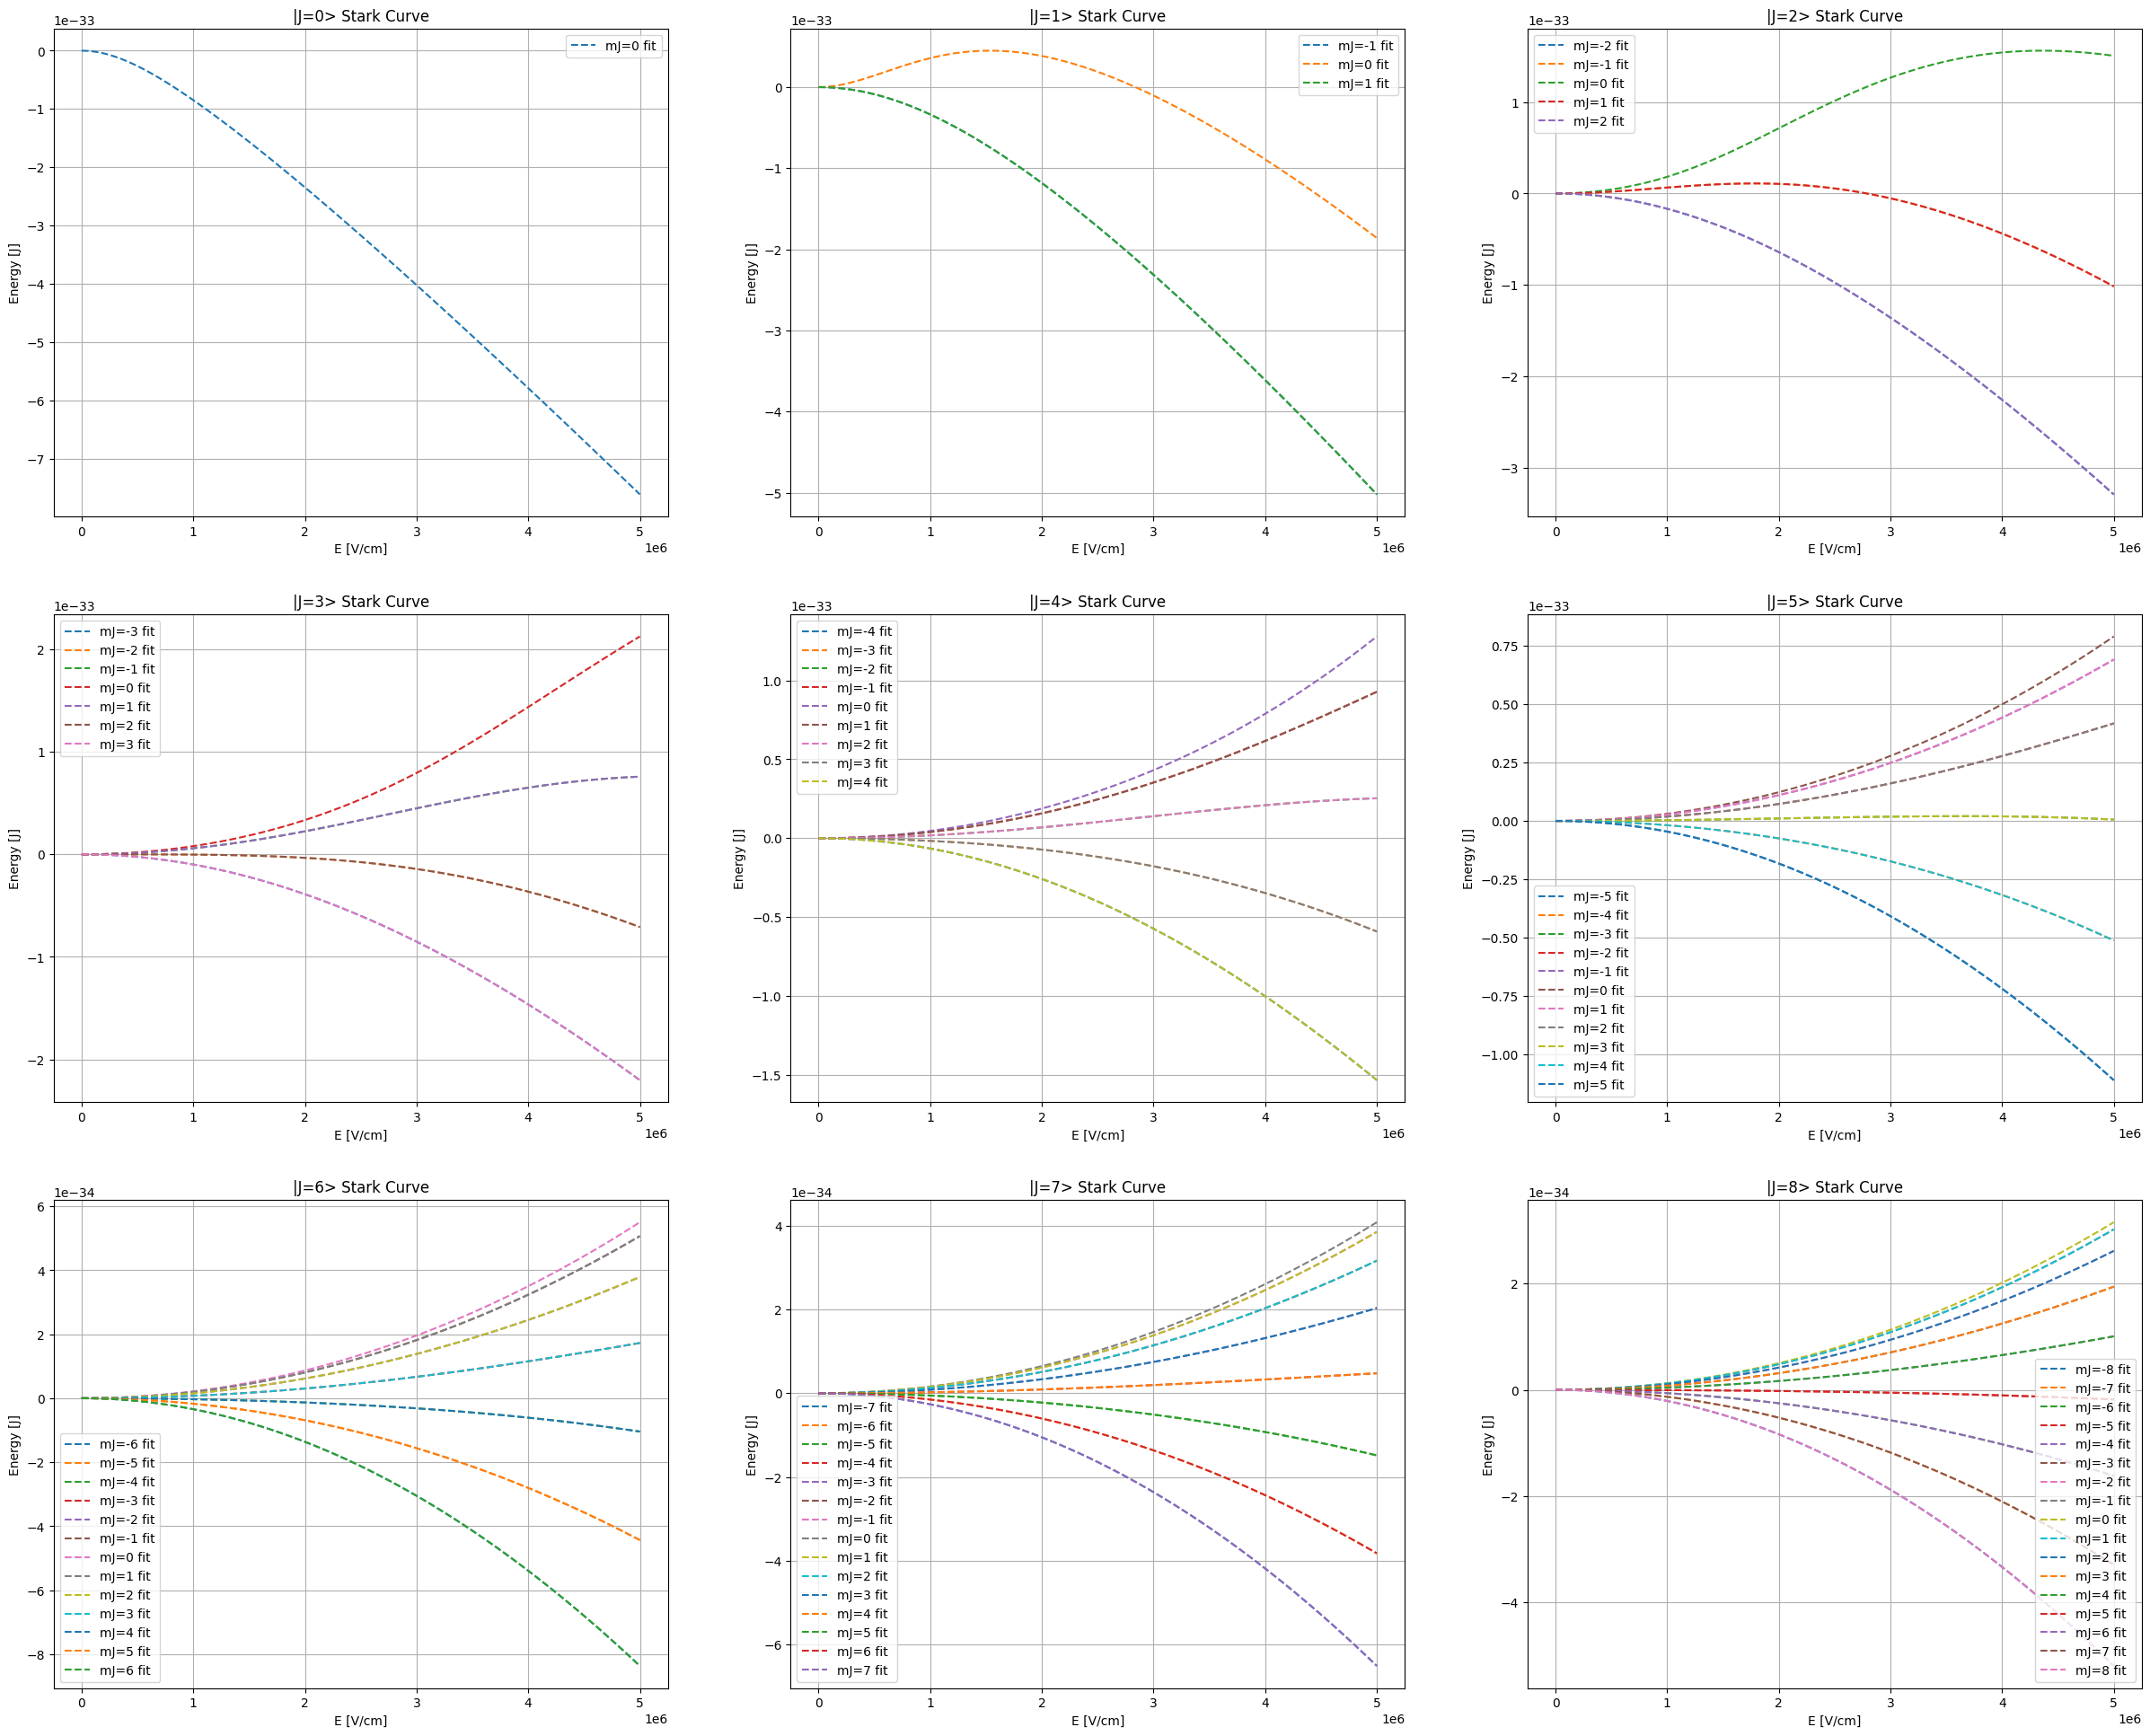

In [23]:
plt.rcParams["figure.figsize"] = (30,24)

fig, axs = plt.subplots(3,3)
J = 0
Ez_Vm = Ez * 100
for i in range(0,3):
    for j in range(0,3):
        for k in range(0, 2*(J)+1):
            energy = stark_potential_j_mj[J][k][0] * constants.hbar
            # p = axs[i, j].plot(Ez_Vm, energy, label=f"mJ={k-J}", alpha=0.3)
            fit_coeff = fit_stark_potential(Ez_Vm, energy, deg=11)
            fit = np.polynomial.Polynomial(coef=fit_coeff)
            # color = p[-1].get_color()
            axs[i, j].plot(Ez_Vm, fit(Ez_Vm), label=f"mJ={k-J} fit", linestyle='dashed')
            with open(f"stark_poly/stark_poly_J{J}_mJ{k-J}.pkl", "wb") as f:
                pickle.dump(fit_coeff, f)

        axs[i, j].set_xlabel("E [V/cm]")
        axs[i, j].set_ylabel("Energy [J]")
        axs[i, j].set_title(f"|J={J}> Stark Curve")
        axs[i, j].grid(True)
        axs[i, j].legend()
        J = J+1